In [ ]:
!pip install pytorch-lightning --quiet
!pip install jax[cuda11_cudnn82] jaxlib --upgrade --quiet
!pip install -q git+https://www.github.com/google/neural-tangents.git@no_experimental

import os
import sys

if os.path.isdir('/content/eigenlearning'):
    !rm -r '/content/eigenlearning'
!git clone -q https://github.com/james-simon/eigenlearning.git
sys.path.insert(0,'/content/eigenlearning')

!pip3 install pickle5
import pickle5 as pickle

In [22]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

DIRECTORY = 'eigenlearning/'

main_dir = '/content/drive/MyDrive/' + DIRECTORY
expt_dir = main_dir + 'deep_bootstrap/'
for dir in [main_dir, expt_dir]:
    if not os.path.exists(dir):
        os.makedirs(dir)

Mounted at /content/drive


In [23]:
import numpy as np
import jax
from jax import numpy as jnp
import matplotlib
import matplotlib.pyplot as plt
import time

import torch
from torch import nn
import torch.nn.functional as F
from torchvision import transforms
from torchvision.datasets import CIFAR10
from torchvision.models import resnet18
from torch.utils.data import Dataset, DataLoader, random_split

import pytorch_lightning as pl
import torchmetrics

from pytorch_lightning.callbacks.progress import TQDMProgressBar
from pytorch_lightning.callbacks import LearningRateMonitor, EarlyStopping
from pytorch_lightning.loggers import CSVLogger, TensorBoardLogger

import shutil

In [ ]:
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from matplotlib.colors import hsv_to_rgb

def rcsetup():
    plt.rc("figure", dpi=150, facecolor=(1, 1, 1), figsize=(6, 3.5))
    plt.rc("font", family='stixgeneral', size=18)
    plt.rc("axes", titlesize=19)
    # plt.rc("axes", facecolor=(1, .99, .95))
    plt.rc("mathtext", fontset='cm')

def get_plot_color(ind, ncolors=10):
    from matplotlib.colors import hsv_to_rgb
    colorlist = ["xkcd:blue", "xkcd:pumpkin", "xkcd:moss", "xkcd:lavender", "xkcd:goldenrod", "xkcd:puce", "xkcd:crimson"]
    colorlist = [hsv_to_rgb((h,1,.7)) for h in np.linspace(0, 0.8, ncolors)]
    ncolors = len(colorlist)
    return colorlist[ind%ncolors]

plt.rcdefaults()
rcsetup()

In [29]:
def powerlaw_spectrum(alpha, beta, M):
    idxs = np.arange(1,M+1) * 1.

    eigenvalues = idxs**-alpha
    spectrum = Spectrum(eigenvalues)

    eigenlevel_coeffs_sq = idxs**-beta
    eigenlevel_coeffs_sq /= eigenlevel_coeffs_sq.sum()

    return spectrum, np.sqrt(eigenlevel_coeffs_sq)

def get_mse_theory(spectrum, eigenlevel_coeffs, n_trains, tau_effs):
    mse_results = {}
    
    for n_train in n_trains:
        ridges = n_train / tau_effs
        test_mses_theory, train_mses_theory = [], []
        for ridge in ridges:
            theory_pred = theoretical_predictions(n_train, eigenlevel_coeffs, spectrum, ridge=ridge)
            test_mses_theory.append(theory_pred["test_mse"])
            train_mses_theory.append(theory_pred["train_mse"])
        mse_results[n_train] = train_mses_theory, test_mses_theory

    return mse_results

# Synthetic experiments

In [30]:
alpha = 2
beta = alpha
M = 500000
spectrum, eigenlevel_coeffs = powerlaw_spectrum(alpha, beta, M)

n_trains = [16, 125, 1000, 8000, 256000]
tau_effs = np.array([10**i for i in np.linspace(-2, 12, 30)])

theory_results = get_mse_theory(spectrum, eigenlevel_coeffs, n_trains, tau_effs)
save_results = {
    "alpha": alpha,
    "beta": beta,
    "spectrum": spectrum,
    "M": M,
    "n_trains": n_trains,
    "tau_effs": tau_effs,
    "results": theory_results
}

with open(expt_dir+"synth_spectrum_{}_theory.pickle".format(alpha), "wb") as handle:
    pickle.dump(save_results, handle, protocol=pickle.HIGHEST_PROTOCOL)

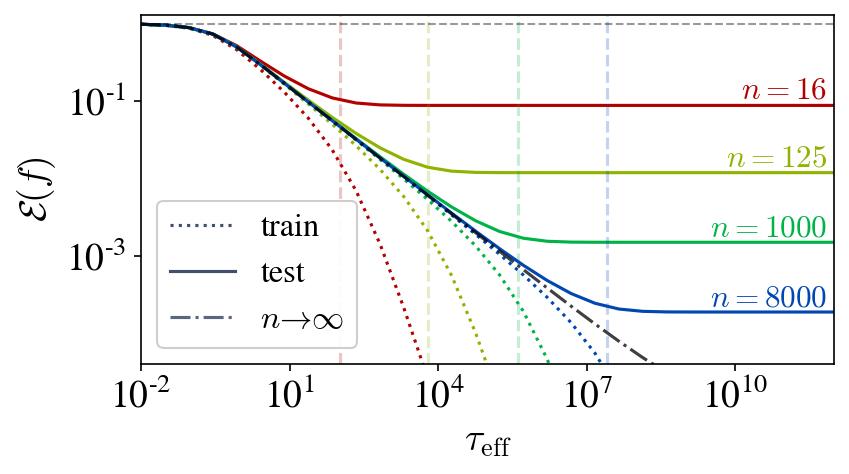

In [44]:
##############
## PLOTTING ##
##############

alpha = 2
with open(expt_dir+"synth_spectrum_{}_theory.pickle".format(alpha), "rb") as handle:
    synth_metadata = pickle.load(handle)
            
fig, ax = plt.subplots()

M = synth_metadata['M']
tau_effs = synth_metadata['tau_effs']
n_trains = synth_metadata['n_trains']
synth_results = synth_metadata['results']

label_pos = [.76, .565, .365, .165]
for i, n in enumerate(n_trains):
    train_mse, test_mse = map(np.array, synth_results[n])

    # Correction
    test_mse = 1/(M-n+1e-4) * (M * test_mse - n * train_mse)

    if i < len(n_trains) - 1:
        color = get_plot_color(i, len(n_trains))
        ax.text(0.99, label_pos[i], r'$n={}$'.format(n), color=color, ha='right', transform=ax.transAxes, fontsize=15)
        kappa_0 = ((np.pi / alpha) / np.sin(np.pi / alpha) / n) ** alpha
        ax.axvline(1/kappa_0, ls="--", color=color, alpha=0.23)

        ax.plot(tau_effs, test_mse, color=color, ls='-')
        ax.plot(tau_effs, train_mse, color=color, ls=':')
    else:
        color = (0, 0, 0, .75)
        ax.plot(tau_effs, test_mse, color=color, ls='-.')


ax.set_xlabel(r'$\tau_\mathrm{eff}$')
ax.set_ylabel(r'$\mathcal{E}(f)$')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(4e-5,1.3e0)
ax.set_xlim(1e-2,1e12)
plt.legend(
        (
            Line2D([0], [0], color='xkcd:navy', alpha=.75, ls=":"),
            Line2D([0], [0], color='xkcd:navy', alpha=.75, ls="-"),
            Line2D([0], [0], color='xkcd:navy', alpha=.65, ls="-."),),
        (
            "train",
            "test",
            r"$n\to\infty$"),
        framealpha=0.95,
        fontsize=15.5,
        loc='lower left',

    )
plt.axhline(1, ls='--', color='black', lw=1, alpha=0.4)
plt.tight_layout()
plt.show()
# plt.savefig("KRR_synthetic_deep_bootstrap.pdf", bbox_inches='tight')

# MNIST KRR (theory vs empirical)

In [36]:
net_fns = get_net_fns(width=500, d_out=1, n_hidden_layers=4)
kernel_fn = net_fns[2]
key = jnp.array([0, 42], dtype='uint32')

# binarize MNIST
classes = [[0,1,2,3,4], [5,6,7,8,9]]

In [37]:
from jax import random

M = 30000

if M <= 16000:
    domain = ImageData('mnist')
    key, dataset_key = random.split(key, 2)
    train_X, train_y, _, _ = domain.get_dataset(n_train=M, classes=classes, subkey=dataset_key)
    eigendata = domain.get_eigendata(kernel_fn, train_X, train_y)
    spectrum = eigendata["spectrum"]
    eigenlevel_coeffs = eigendata["eigenlevel_coeffs"]
if M == 30000:
    with open(expt_dir+"mnist_30k_eigendata.pickle", "rb") as handle:
        eigendata = pickle.load(handle)
    eigenvalues = eigendata['eigenvals']
    eigenlevel_coeffs = eigendata['eigenlevel_coeffs']
    spectrum = Spectrum(eigenvalues)
    eigenlevel_coeffs = eigenlevel_coeffs[spectrum.sort_order]

n_trains = [16, 125, 1000, 8000]
tau_effs = np.array([10**i for i in np.linspace(-2, 8, 30)])
theory_results = get_mse_theory(spectrum, eigenlevel_coeffs, n_trains, tau_effs)
save_results = {
    "spectrum": spectrum,
    "M": M,
    "classes": classes,
    "n_trains": n_trains,
    "tau_effs": tau_effs,
    "results": theory_results
}

with open(expt_dir+"mnist30k_theory.pickle", "wb") as handle:
    pickle.dump(save_results, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [20]:
n_trains = [16, 125, 1000, 8000]
tau_effs = np.array([10**i for i in np.linspace(-2, 8, 30)])
num_trials = 10

domain = ImageData('mnist')

expt_results = {}
    
for n_train in n_trains:
    ridges = n_train / tau_effs
    train_mses, test_mses = [], []
    for ridge in ridges:
        train_mse_trials = []
        test_mse_trials = []
        for _ in range(num_trials):
            key, dataset_key = random.split(key, 2)
            dataset = domain.get_dataset(n_train, classes=classes, subkey=dataset_key)
            _, y_train, _, y_test = dataset
            
            krn_train_y_hat, krn_test_y_hat = train_kernel(kernel_fn, dataset, ridge=ridge)
            _, train_mse, _, _ = compute_metrics(y_train, krn_train_y_hat)
            _, test_mse, _, _ = compute_metrics(y_test, krn_test_y_hat)
            train_mse_trials.append(train_mse)
            test_mse_trials.append(test_mse)
        train_mses.append(train_mse_trials)
        test_mses.append(test_mse_trials)
        print('.', end='')
    expt_results[n_train] = (train_mses, test_mses)
    print()

save_results = {
    "classes": classes,
    "n_trains": n_trains,
    "tau_effs": tau_effs,
    "n_trials": num_trials,
    "results": expt_results
}

with open(expt_dir+"mnist30k_expt.pickle", "wb") as handle:
    pickle.dump(save_results, handle, protocol=pickle.HIGHEST_PROTOCOL)

..............................
..............................
..............................
..............................


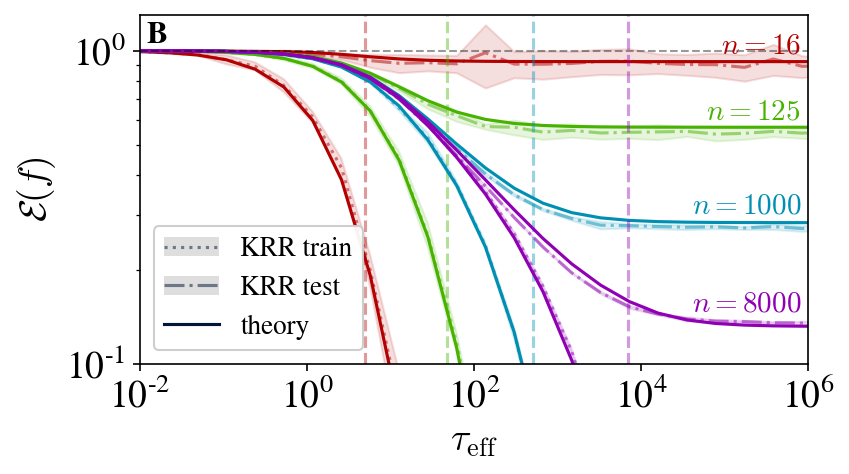

In [45]:
##############
## PLOTTING ##
##############

with open(expt_dir+"mnist30k_theory.pickle", "rb") as handle:
    theory_metadata = pickle.load(handle)
with open(expt_dir+"mnist30k_expt.pickle", "rb") as handle:
    expt_metadata = pickle.load(handle)
            
fig, ax = plt.subplots()

M = theory_metadata['M']
spectrum = theory_metadata['spectrum']
tau_effs = theory_metadata['tau_effs']
n_trains = theory_metadata['n_trains']
theory_results = theory_metadata["results"]
expt_results = expt_metadata["results"]

label_pos = [.89, .7, .43, .15]
for i, n in enumerate(n_trains):
    theory_train_mse, theory_test_mse = map(np.array, theory_results[n])
    # Correction
    theory_test_mse = 1/(M-n) * (M * theory_test_mse - n * theory_train_mse)

    train_mses, test_mses = expt_results[n]
    train_mses, test_mses = np.array(train_mses), np.array(test_mses)
    train_mse_mean = np.mean(train_mses, axis=-1)
    train_mse_std = np.std(train_mses, axis=-1)
    test_mse_mean = np.mean(test_mses, axis=-1)
    test_mse_std = np.std(test_mses, axis=-1)

    color = get_plot_color(i, len(n_trains))
    kappa_0 = find_kappa(n, spectrum, ridge=0)
    ax.axvline(1/kappa_0, ls="--", color=color, alpha=0.4)

    ax.plot(tau_effs, theory_test_mse, color=color)#, label=n)
    ax.plot(tau_effs, theory_train_mse, color=color)

    ax.plot(tau_effs, test_mse_mean, ls="-.", color=color, alpha=0.5)
    ax.fill_between(tau_effs, test_mse_mean-test_mse_std, test_mse_mean+test_mse_std, color=color, alpha=0.13)
    ax.plot(tau_effs, train_mse_mean, ls=":", color=color, alpha=0.5)
    ax.fill_between(tau_effs, train_mse_mean-train_mse_std, train_mse_mean+train_mse_std, color=color, alpha=0.13)

    ax.text(0.99, label_pos[i], r'$n={}$'.format(n), color=color, ha='right', transform=ax.transAxes, fontsize=14)

ax.text(0.01, .92, "B", color='black', transform=ax.transAxes, fontsize=15, fontweight='bold')
ax.set_xlabel(r'$\tau_\mathrm{eff}$')
ax.set_ylabel(r'$\mathcal{E}(f)$')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(10e-2,1.3e0)
ax.set_xlim(1e-2,1e6)
plt.legend(
    (
        (Line2D([0], [0], color='xkcd:navy', alpha=.5, ls=":"), Patch(color='k', alpha=0.13, lw=0)),
        (Line2D([0], [0], color='xkcd:navy', alpha=.5, ls="-."), Patch(color='k', alpha=0.13, lw=0)),
        Line2D([0], [0], color='xkcd:navy'),),
    (
        "KRR train",
        "KRR test",
        "theory",),
     framealpha=0.95, fontsize=13)
plt.axhline(1, ls='--', color='black', lw=1, alpha=0.4)
plt.tight_layout()
plt.show()
# plt.savefig("KRR_deep_bootstrap.pdf", bbox_inches='tight')

# Neural networks

In [ ]:
def modified_resnet():
    model = resnet18(num_classes=10)
    model.conv1 = nn.Conv2d(3, 64, kernel_size=(3, 3), stride=1, padding=1, bias=False)
    model.maxpool = nn.Identity()
    return model

class SoftError(torchmetrics.Metric):
    full_state_update = False

    def __init__(self):
        super().__init__()
        self.add_state("correct", default=torch.tensor(0.), dist_reduce_fx="sum")
        self.add_state("total", default=torch.tensor(0.), dist_reduce_fx="sum")

    def update(self, preds: torch.Tensor, target: torch.Tensor):
        soft = preds[range(preds.shape[0]), target]

        self.correct += target.numel() - torch.sum(soft)
        self.total += target.numel()

    def compute(self):
        return self.correct / self.total


class LitResnet(pl.LightningModule):

    def __init__(self, lr=0.1, dataset_size=50000):
        super().__init__()

        self.rng = torch.Generator().manual_seed(40)
        self.lr = lr

        self.n_classes = 10
        self.dims = (3, 32, 32)
        self.datasize = dataset_size

        self.model = modified_resnet()

        self.test_error = 1 - torchmetrics.Accuracy()
        self.train_error = 1 - torchmetrics.Accuracy()
        self.soft_error = SoftError()

        self.train_step_num = 0
        

    def forward(self, x):
        out = self.model(x)
        return F.log_softmax(out, dim=1)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.nll_loss(logits, y)
        preds = torch.argmax(logits, dim=1)
        self.train_error.update(preds, y)

        self.log("TrainLoss", loss)
        self.train_step_num += 1
        return loss

    def training_epoch_end(self, outs):
        pass

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        preds = torch.argmax(logits, dim=1)
        self.test_error.update(preds, y)
        self.soft_error.update(torch.exp(logits), y)

        self.log("TestError", self.test_error, prog_bar=True)
        self.log("SoftError", self.soft_error)
        if self.train_step_num > 0:
            self.log("TrainError", self.train_error)

    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        x, y = batch
        y_hat = self.model(x)
        return y_hat

    def configure_optimizers(self):
        optimizer = torch.optim.SGD(
            self.parameters(),
            lr=self.lr,
            momentum=0.9,
        )
        max_epochs = MAX_STEPS / self.datasize * BATCH_SZ
        scheduler_dict = {
            "scheduler": torch.optim.lr_scheduler.CosineAnnealingLR(
                optimizer,
                T_max=max_epochs
            ),
            "interval": "epoch",
        }
        return {"optimizer": optimizer, "lr_scheduler": scheduler_dict}

    ####################
    # DATA RELATED HOOKS
    ####################

    def prepare_data(self):
        # download data
        CIFAR10("cifar10/", download=True)
    
    def setup(self, stage):
        train_transforms = transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomCrop(32, padding=4),
            transforms.ToTensor(),
        ])
        self.traindata = CIFAR10("cifar10/", train=True, download=True,
                                 transform=train_transforms)
        self.testdata = CIFAR10("cifar10/", train=False, download=True,
                                transform=transforms.ToTensor())

    def train_dataloader(self):
        small_trainset, _ = random_split(self.traindata,
                                         [self.datasize, len(self.traindata)-self.datasize])
        return DataLoader(small_trainset, batch_size=BATCH_SZ, num_workers=2, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.testdata, batch_size=BATCH_SZ, num_workers=2)


from pytorch_lightning.loops.epoch import TrainingEpochLoop
class LogValLoop(TrainingEpochLoop):

    def set_val_schedule(self, val_schedule):
        self.val_sched = val_schedule
    
    def _should_check_val_fx(self) -> bool:
        """Decide if we should run validation."""
        if not self._should_check_val_epoch():
            return False

        # val_check_batch is inf for iterable datasets with no length defined
        is_infinite_dataset = self.trainer.val_check_batch == float("inf")
        is_last_batch = self.batch_progress.is_last_batch
        if is_last_batch and is_infinite_dataset:
            return True

        if self.trainer.should_stop:
            return True

        # TODO(@awaelchli): let training/eval loop handle logic around limit_*_batches and val_check_batch
        is_val_check_batch = is_last_batch
        if isinstance(self.trainer.limit_train_batches, int) and is_infinite_dataset:
            is_val_check_batch = (self.batch_idx + 1) % self.trainer.limit_train_batches == 0
        elif self.trainer.val_check_batch != float("inf"):
            # if `check_val_every_n_epoch is `None`, run a validation loop every n training batches
            # else condition it based on the batch_idx of the current epoch
            current_iteration = self.total_batch_idx if self.trainer.check_val_every_n_epoch is None else self.batch_idx
            is_val_check_batch = (current_iteration + 1) % self.trainer.val_check_batch == 0

        
        if self.val_sched is not None:
            threshold = self.val_sched[0] if len(self.val_sched)>0 else np.inf
            if self.total_batch_idx < threshold:
                return False
            else:
                self.val_sched = self.val_sched[1:]
                return True
        return is_val_check_batch

In [ ]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SZ = 128 if torch.cuda.is_available() else 64
MAX_STEPS = 15000

torch.manual_seed(42)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

In [ ]:
%reload_ext tensorboard
%tensorboard --logdir=lightning_logs/

In [ ]:
count = 0
max_steps = [4000, 6000, 10000, 14000]
ns =  [500, 2000, 8000, 32000]
n_trials = 5
val_sched = np.geomspace(10, 13800, 50).astype(int)

exp_details = {
    "ns": ns,
    "n_trials": n_trials,
    "val_sched": val_sched
}
with open(expt_dir+"NN_DB_expt_details.pickle", "wb") as handle:
    pickle.dump(exp_details, handle, protocol=pickle.HIGHEST_PROTOCOL)

for run in range(n_trials):
    for i, n in enumerate(ns):
        model = LitResnet(lr=0.1, dataset_size=n)

        loggers = [TensorBoardLogger(save_dir="."),
                CSVLogger(save_dir=".")]

        trainer = pl.Trainer(
            accelerator="auto",
            devices=1 if torch.cuda.is_available() else None,
            callbacks=[TQDMProgressBar(refresh_rate=1),
                       LearningRateMonitor(),],
            logger=loggers,
            log_every_n_steps=20,
            val_check_interval=10, check_val_every_n_epoch=None,
        )
        val_loop = LogValLoop(max_steps=max_steps[i])
        val_loop.set_val_schedule(val_sched)
        val_loop.trainer = trainer
        trainer.fit_loop.connect(epoch_loop=val_loop)
        trainer.fit(model)

        exp_name = '{}'.format(n)
        version = count
        shutil.move("/content/lightning_logs/version_{}/metrics.csv".format(version),
                    expt_dir+"nn_metrics_{}_{}.csv".format(exp_name, run)) 
        count += 1

        del model

In [ ]:
# !rm -rf lightning_logs

In [ ]:
##############
## PLOTTING ##
##############

import csv
from scipy.ndimage import gaussian_filter1d

with open(expt_dir+"NN_DB_expt_details.pickle", "rb") as handle:
    exp_details = pickle.load(handle)

ns = exp_details['ns']
n_trials = exp_details['n_trials']
trainsteps = exp_details['val_sched']

all_data = {}
skip = []
for n in ns:
    for run in range(n_trials):
        if run in skip:
            continue
        exp_name = str(n)
        fname = expt_dir+"nn_metrics_{}_{}.csv".format(exp_name, run)
        with open(fname, 'r', newline='') as csvfile:
            reader = csv.reader(csvfile, delimiter=',', quotechar='|')
            lines = list(reader)
            header, table = lines[0], lines[1:]
            run_data = {}
            for i, metric in enumerate(header):
                steps = [float(line[1]) for line in table if line[i]!='']
                data = [float(line[i]) for line in table if line[i]!='']
                run_data[metric] = (steps, data)
            all_data["{}_{}".format(exp_name, run)] = run_data

def make_DB_plot(all_data, log=True, train=True, error=False):
    ax = plt.gca()
    x = np.hstack((trainsteps, [1e5])).astype(int)
    label_pos = [.79, .645, .38, .165]
    for i, n in enumerate(ns):
        for metric in ["TestError", "TrainError"]:
            y = []
            for run in range(n_trials):
                if run in skip:
                    continue
                exp_name = '{}'.format(n)
                steps, data = all_data["{}_{}".format(exp_name, run)][metric]
                data = data + data[-1:]*(len(x)-len(data))
                y.append(data)
            yerr = np.std(y, axis=0)
            y = np.mean(y, axis=0)
            y_smooth = y.copy()
            y_smooth[1:] = gaussian_filter1d(y_smooth[1:], sigma=1, mode='nearest')
            yerr_smooth = gaussian_filter1d(yerr, sigma=1, mode='nearest')

            color = get_plot_color(i, len(ns))
            if metric == "TestError":
                plt.plot(x, y_smooth, '-', label=n, color=color, alpha=0.85)
                if error:
                    ax.fill_between(x, y_smooth-yerr_smooth, y_smooth+yerr_smooth, color=color, alpha=0.13)
            else:
                if train:
                    plt.plot(x, y_smooth, ':', color=color)
                    if error:
                        ax.fill_between(x, y_smooth-yerr_smooth, y_smooth+yerr_smooth, color=color, alpha=0.13)
        
        ax.text(0.99, label_pos[i], r'$n={}$'.format(n), color=color, ha='right', transform=ax.transAxes, fontsize=14)
    
    ax.text(0.01, .92, "A", color='black', transform=ax.transAxes, fontsize=15, fontweight='bold')
    if log:
        plt.xscale('log')
        plt.yscale('log')
        if train:
            plt.ylim(7e-2, 1.2e0)
        else:
            plt.ylim(7e-2, 1e0)
        plt.xlim(1e1, 6e4)
    else:
        plt.ylim(0, 1e0)
        plt.xlim(0, 1.3e4)

    plt.legend(
        (
            Line2D([0], [0], color='xkcd:navy', alpha=.65, ls=":"),
            Line2D([0], [0], color='xkcd:navy', alpha=.65, ls="-"),),
        (
            "NN train",
            "NN test",),
        framealpha=0.95)
    plt.xlabel('Train steps')
    plt.ylabel("Classification Error")
    plt.tight_layout()
    plt.axhline(0.9, ls='--', color='black', lw=1, alpha=0.4)

    names = [
        "train" if train else "test",
        "err" if error else "noerr",
        "log" if log else "lin"
    ]
    fname = "_".join(names)
    # plt.show()
    plt.savefig("NN_deep_bootstrap.pdf", bbox_inches='tight')

make_DB_plot(all_data)